In [31]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os, psutil
import scipy 

In [32]:
class CIR:
    def __init__(self, tau, alpha, beta, seed=None):
        self.tau = tau
        self.alpha = alpha
        self.beta = beta
        self.rng = (
            default_rng(np.round(np.pi * 1e10).astype(int)) 
            if seed is None else default_rng(seed)
        )

    def sample_wiener_increments(self, num_paths, num_timepoints, delta_t):
        return (
            self.rng.standard_normal((num_paths, num_timepoints)) 
            * np.sqrt(delta_t)
        )

    def sample_ncx2(self, dof, lambda_):
        return scipy.stats.ncx2.rvs(dof, lambda_, random_state=self.rng)

    def __call__(self, x_0, num_paths, num_timesteps, delta_t, method):
        # TODO: add validation logic for x_0 (should be 1D array)

        # Preallocate and set initial value.
        x = np.full((num_paths, num_timesteps), fill_value=np.nan)
        x[:, 0] = x_0

        if method == 'euler_maruyama':
            dW = self.sample_wiener_increments(num_paths, num_timesteps, delta_t)
            kappa = 1 / self.tau
            sigma = np.sqrt(2 / (self.tau * self.beta))
            theta = self.alpha / self.beta
            for i_timestep in range(num_timesteps-1):
                dX = (
                    kappa * (theta - x[:, i_timestep]) * delta_t
                    + sigma * np.sqrt(x[:, i_timestep]) * dW[:, i_timestep]
                )
                x[:, i_timestep+1] = x[:, i_timestep] + dX

            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'theta' : theta, 
                'sigma' : sigma
            }

        elif method == 'ncx2':
            # Precompute necessary parameters for sampling.
            kappa = 1 / self.tau
            sigma_sqr = 2 / (self.tau * self.beta)
            upsilon = np.exp(-kappa * delta_t)
            eta = (
                4 * kappa * upsilon 
                / (sigma_sqr * (1 - upsilon))
            )
            dof = 4 * kappa * (self.alpha / self.beta) / sigma_sqr

            # Iteratively update via sampling.
            for i_timestep in range(num_timesteps-1):
                x[:, i_timestep + 1] \
                    = self.sample_ncx2(dof, eta * x[:, i_timestep])
                
            # Collect params to be returned.
            params = {
                'kappa' : kappa,
                'sigma_sqr' : sigma_sqr,
                'eta' : eta,
                'dof' : dof
            }

        return x, params



In [33]:

params = {
    'rate' : 10,
    'parameters' : {
        'tau' : 0.1,
        'beta' : 5,
    },
    'simulation' : {
        'num_paths' : 150,
        'num_timesteps' : 5000,
        'delta_t' : 0.000125, 
        'method' : 'euler_maruyama'
    }
}

params['parameters']['alpha'] = params['parameters']['beta'] * params['rate']
params['simulation']['x_0'] = np.zeros((params['simulation']['num_paths'],))

cir = CIR(**params['parameters'])




[[0.         0.0125     0.02349741 ... 2.56983467 2.60719991 2.60888519]
 [0.         0.0125     0.02399855 ... 2.32499777 2.30955016 2.31487065]
 [0.         0.0125     0.02178095 ... 2.02586093 2.0105347  2.04221499]
 ...
 [0.         0.0125     0.02586452 ... 2.18796709 2.21383557 2.19620243]
 [0.         0.0125     0.0236181  ... 2.73767214 2.76280034 2.79427195]
 [0.         0.0125     0.02916382 ... 1.65448781 1.64929503 1.68625407]]


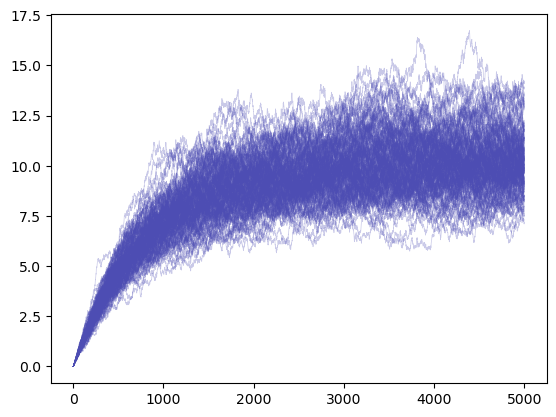

In [34]:
x, sim_params = cir(**params['simulation'])

print(x[:, :200])

fig, ax = plt.subplots()
for i_path in range(x.shape[0]):
    ax.plot(x[i_path, :], color=(0.3, 0.3, 0.7), alpha=0.3, linewidth=0.5)



### Simulate Poisson process

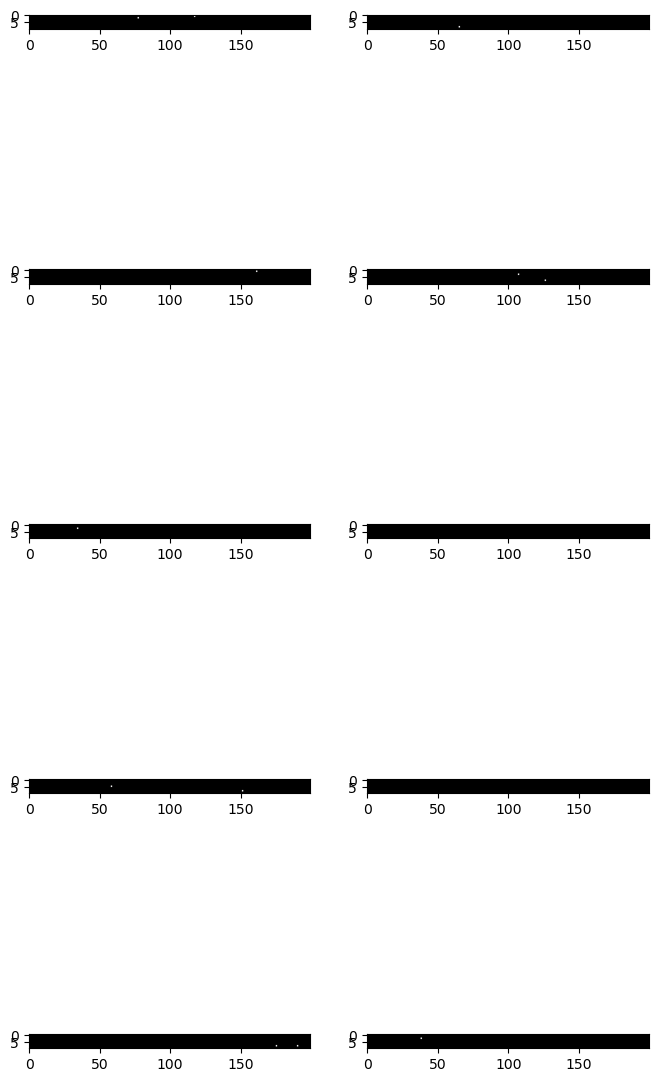

In [35]:
params['poisson_process'] = {
    'num_inputs_per_path' : 1000
}

num_rows, num_cols = 5, 2
fig_1, axs_1 = plt.subplots(num_rows, num_cols, figsize=(8, 16))

spikes = np.full(
    (x.shape[0], params['poisson_process']['num_inputs_per_path'], x.shape[1]), 
    np.nan
)
for i_path in range(x.shape[0]):
    lambda_ = x[i_path, :] * params['simulation']['delta_t']
    p = lambda_ * np.exp(-lambda_)
    u = cir.rng.random(
        (
            params['poisson_process']['num_inputs_per_path'],
            params['simulation']['num_timesteps']
        )
    )
    spikes[i_path, :, :] = (p[np.newaxis, :] > u).astype(int)

    i_row, i_col = divmod(i_path, 2)
    if i_row <= num_rows-1 and i_col <= num_cols-1:
        axs_1[i_row, i_col].imshow(spikes[i_path, :10, 1000:1200], cmap='gray')

# Convert to bool for space efficiency.
spikes = spikes.astype(np.uint8)
    

In [36]:
# def get_conductance_process(spikes, kernel, delta_t):
#     """ 
#     spikes is 1d array of spikes for single neuron for single path.
#     """
#     # Get indices of all spikes for current neuron.
#     spike_ind = np.where(spikes)[0][:, np.newaxis]
#     num_timepoints = len(spikes)
#     num_spikes = len(spike_ind)

#     # Prepare inputs to kernel function (t).
#     t = np.zeros((num_spikes, num_timepoints))
#     col_ind = np.arange(num_timepoints)[np.newaxis, :]
#     mask = col_ind >= spike_ind 
#     sequences = (col_ind - spike_ind) * delta_t
#     t[mask] = sequences[mask]

#     # Prepare Heaviside functions.
#     heavisides = np.zeros(t.shape)
#     heavisides[mask] = 1
    
#     # Apply kernel.
#     conductances = np.sum(kernel(t) * heavisides, axis=0)

#     return conductances

    
# # Get conductance timeseries for each path.
# membrane_tau = 0.02
# h_k = 0.1 # synaptic conductance
# params['conductance_process'] = {
#     'tau' : membrane_tau,
#     'h_k' : h_k,
#     'kernel' : lambda x: h_k * np.exp(-x / membrane_tau)
# }

# conductances = np.full(spikes.shape, np.nan)
# for i_path in range(x.shape[0]):
#     for i_input in range(params['poisson_process']['num_inputs_per_path']):

#         print(f"[{i_path=}, {i_input=}]")

#         # Get current neuron for current path.
#         conductances[i_path, i_input, :] = get_conductance_process(
#             spikes[i_path, i_input, :].squeeze(), 
#             params['conductance_process']['kernel'],
#             params['simulation']['delta_t']
#         )







In [37]:
# import os, psutil

# process = psutil.Process(os.getpid())

# def get_conductance_process(spikes, kernel, delta_t):
#     """ 
#     spikes is 2d array (num_inputs, num_timepoints) of spikes for multiple 
#     input neurons for a single path.
#     """
#     num_inputs, num_timepoints = spikes.shape

#     # Get indices of all spikes for all neurons.
#     spike_row_ind, spike_col_ind = np.where(spikes)
#     spike_col_ind_per_neuron = [
#         spike_col_ind[np.where(spike_row_ind==i_input)[0]]
#         for i_input in range(num_inputs)
#     ]
    
#     # Number of spikes per neuron and max number of spikes across neurons.
#     num_spikes_per_neuron = [
#         len(spike_col_ind) for spike_col_ind in spike_col_ind_per_neuron
#     ]
#     max_num_spikes = max(num_spikes_per_neuron)

#     # Get array of spike indices. Third dim is for broadcasting with time. For
#     # first two dims as rows and cols, first M_j rows of j_th column are spike
#     # times of j_th neuron, for M_j as number of spikes emitted by j_th neuron.
#     spike_ind = np.full((max_num_spikes, num_inputs, 1), np.nan)
#     for i_input in range(num_inputs):
#         spike_ind[:num_spikes_per_neuron[i_input], i_input, 0] \
#             = spike_col_ind_per_neuron[i_input]

#     # Prepare inputs to kernel function (t).
#     t = np.zeros((max_num_spikes, num_inputs, num_timepoints))
#     col_ind = np.arange(num_timepoints)[np.newaxis, np.newaxis, :]
#     mask = col_ind >= spike_ind
#     sequences = (col_ind - spike_ind) * delta_t
#     t[mask] = sequences[mask]

#     # Prepare Heaviside functions.
#     heavisides = np.zeros(t.shape)
#     heavisides[mask] = 1
    
#     # Apply kernel.
#     conductances = np.sum(kernel(t) * heavisides, axis=0)

#     return conductances

# # Get conductance timeseries for each path.
# membrane_tau = 0.02
# h_k = 0.1 # synaptic conductance
# params['conductance_process'] = {
#     'tau' : membrane_tau,
#     'h_k' : h_k,
#     'kernel' : lambda x: h_k * np.exp(-x / membrane_tau)
# }

# conductances = np.full(spikes.shape, np.nan)
# for i_path in range(x.shape[0]):
#     # for i_input in range(params['poisson_process']['num_inputs_per_path']):
#     print(f"{i_path=}")
#     print(f"{i_path=}, mem used: {process.memory_info().rss / 1e6:.2f} MB")
#     # Get current neuron for current path.
#     conductances[i_path, :, :] = get_conductance_process(
#         spikes[i_path, :, :].squeeze(), 
#         params['conductance_process']['kernel'],
#         params['simulation']['delta_t']
#     )

In [38]:
process = psutil.Process(os.getpid())

def get_conductance_process(spikes, delta_t, h, membrane_tau):
    """ 
    Dimensions
    ----------
    N : Number of inputs.
    T : Number of timepoints.

    Parameters
    ----------
    spikes : np.ndarray (N, T)
        i_th, j_th element is 1 if synpase i receives input at timepoint j and 
        0 otherwise.
    h : np.ndarray (N,) or (1,)
        Vector of conductances over pre-synaptic inputs, or global scalar to be
        broadcast for all inputs.
    membrane_tau : float
        Membrane time constant.
    delta_t : flaot
        Size of discretization timestep.

    Returns
    -------
    conductances : np.ndarray (N, T)
        i_th row is conductance trace for i_th input synapse.
    """
    # Prepare filter.
    alpha = np.exp(-delta_t / membrane_tau)
    a = [1, -alpha]
    b = [1]

    # Apply filter and conductance for each input.
    conductances = scipy.signal.lfilter(b, a, spikes, axis=1)
    conductances = conductances * h[:, np.newaxis]

    return conductances

# Set parameters for computing conductance timeseries.
params['conductance_process'] = {
    'membrane_tau' : 0.02,
    'h' : np.array([0.001]), # synaptic conductance
}

# # Get conductance timeseries for each path.
# conductances = np.full(spikes.shape, np.nan)
# for i_path in range(x.shape[0]):
#     # for i_input in range(params['poisson_process']['num_inputs_per_path']):
#     print(f"{i_path=}")
#     print(f"{i_path=}, mem used: {process.memory_info().rss / 1e6:.2f} MB")
#     # Get current neuron for current path.
#     conductances[i_path, :, :] = get_conductance_process(
#         spikes[i_path, :, :].squeeze(), 
#         params['simulation']['delta_t'],
#         **params['conductance_process'],
#     )

# Get conductance timeseries for each path.
results = Parallel(n_jobs=-1)(
    delayed(get_conductance_process)(
        spikes[i_path], 
        params['simulation']['delta_t'], 
        **params['conductance_process']
    )
    for i_path in range(params['simulation']['num_paths'])
)
conductances = np.stack(results)

[0.00071635 0.00071188 0.00070745 0.00070304 0.00069866 0.00069431
 0.00068998 0.00068568 0.00068141 0.00067717 0.00067295 0.00066875
 0.00066459 0.00066045 0.00065633 0.00065224 0.00064818 0.00064414
 0.00064013 0.00063614 0.00063217 0.00062824 0.00062432 0.00062043
 0.00061657 0.00061272 0.00060891 0.00060511 0.00060134 0.0005976
 0.00059387 0.00059017 0.0005865  0.00058284 0.00057921 0.0005756
 0.00057202 0.00056845 0.00056491 0.00056139 0.00055789 0.00055442
 0.00055096 0.00054753 0.00054412 0.00054073 0.00053736 0.00053401
 0.00053068 0.00052738 0.00052409 0.00052083 0.00051758 0.00051436
 0.00051115 0.00050797 0.0005048  0.00050166 0.00049853 0.00049542
 0.00049234 0.00048927 0.00048622 0.00048319 0.00048018 0.00047719
 0.00047422 0.00047126 0.00046833 0.00046541 0.00046251 0.00045963
 0.00045676 0.00045392 0.00045109 0.00044828 0.00044549 0.00044271
 0.00043995 0.00043721 0.00043449 0.00043178 0.00042909 0.00042642
 0.00042376 0.00042112 0.0004185  0.00041589 0.0004133  0.000410

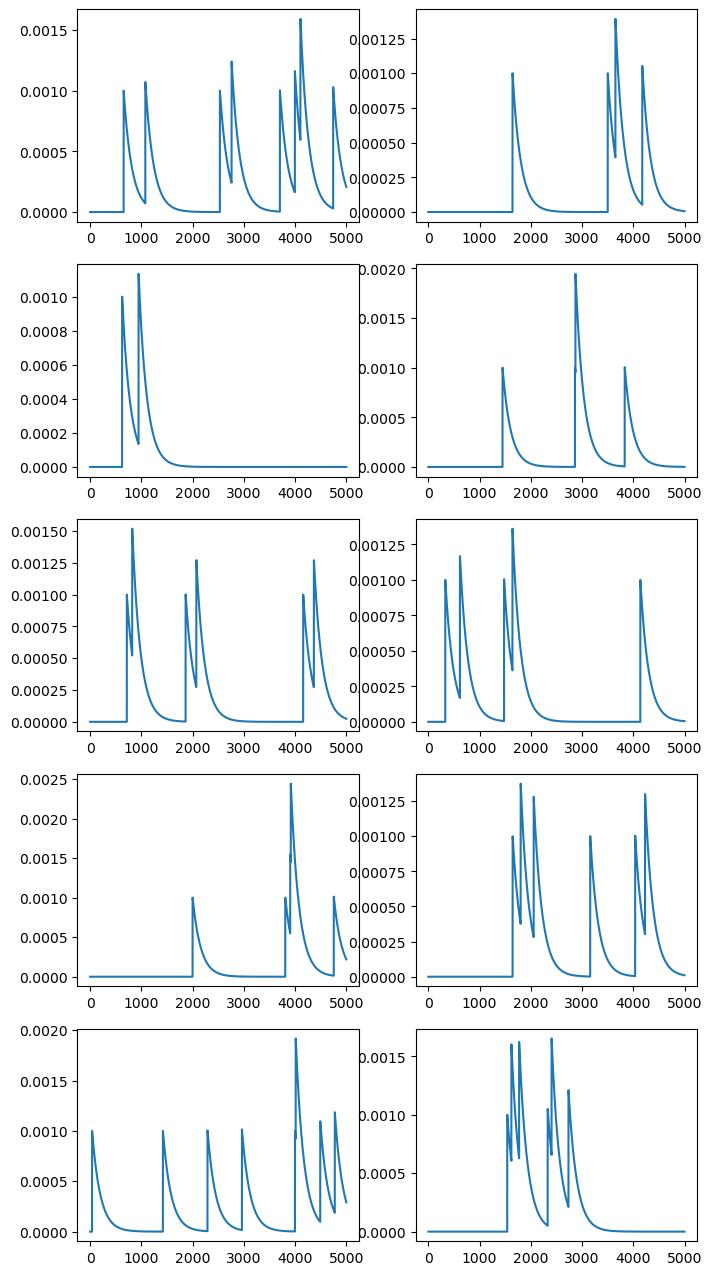

In [39]:
i_input = 2
fig_2, axs_2 = plt.subplots(5, 2, figsize=(8, 16))
for i_path in range(10):
    i_row, i_col = divmod(i_path, 2)
    axs_2[i_row, i_col].plot(conductances[i_path, i_input, :])

    print(conductances[i_path, i_input, -200:])

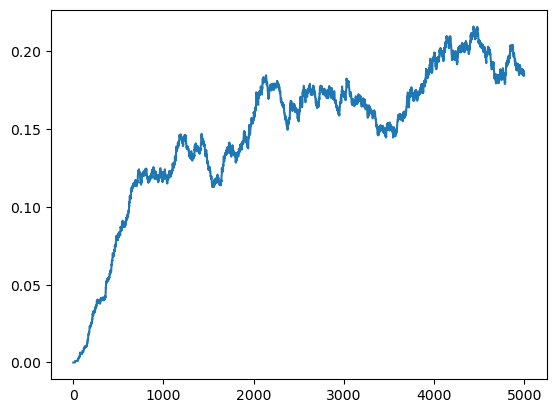

In [40]:
# For each path, sum across neurons to get final conductance process.
total_conductances = np.sum(conductances, axis=1)


plt.plot(total_conductances[1, :])




In [41]:
# For each path, sum across neurons to get final conductance process.
total_conductances = np.sum(conductances, axis=1)

# Parameters for post-synaptic neuron membrane voltage simulation.
t_span = (
    0, 
    params['simulation']['num_timesteps'] * params['simulation']['delta_t'],
)
params['postsynaptic_membrane'] = {
    'tau' : np.array([0.005]),
    'v_e' : np.array([70]),
    'v_0' : np.array([0]),
    't' : np.linspace(t_span[0], t_span[1], params['simulation']['num_timesteps'])
}

# Membrane voltage ODE.
def dv_dt(t, v, g, tau, v_e):
    return -(1 + g(t))/tau * v + g(t)/tau * v_e

solutions = []
for i_path in range(total_conductances.shape[0]):
    # Get total conductance process for current path and interpolate.
    g = scipy.interpolate.interp1d(
        params['postsynaptic_membrane']['t'], 
        total_conductances[i_path, :],
        kind='linear',
        fill_value='extrapolate'
    )

    sol = scipy.integrate.solve_ivp(
        dv_dt, 
        t_span, 
        params['postsynaptic_membrane']['v_0'], 
        t_eval=params['postsynaptic_membrane']['t'],
        args=(
            g, 
            params['postsynaptic_membrane']['tau'],
            params['postsynaptic_membrane']['v_e']
        ),
        method='RK45'
    )

    solutions.append(sol)

    for sol in solutions:
        print(sol)





  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.250e-04 ...  6.249e-01  6.250e-01]
        y: [[ 0.000e+00  0.000e+00 ...  1.081e+01  1.081e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1178
     njev: 0
      nlu: 0
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.250e-04 ...  6.249e-01  6.250e-01]
        y: [[ 0.000e+00  0.000e+00 ...  1.081e+01  1.081e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1178
     njev: 0
      nlu: 0
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.250e-04 ...  6.249e-01  6.250e-01]
        y: [[ 0.000e+00  0.000e+00 ...  1.110e+01  1.110e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1250
     njev: 0
      nlu: 0
  message: The solver successfu

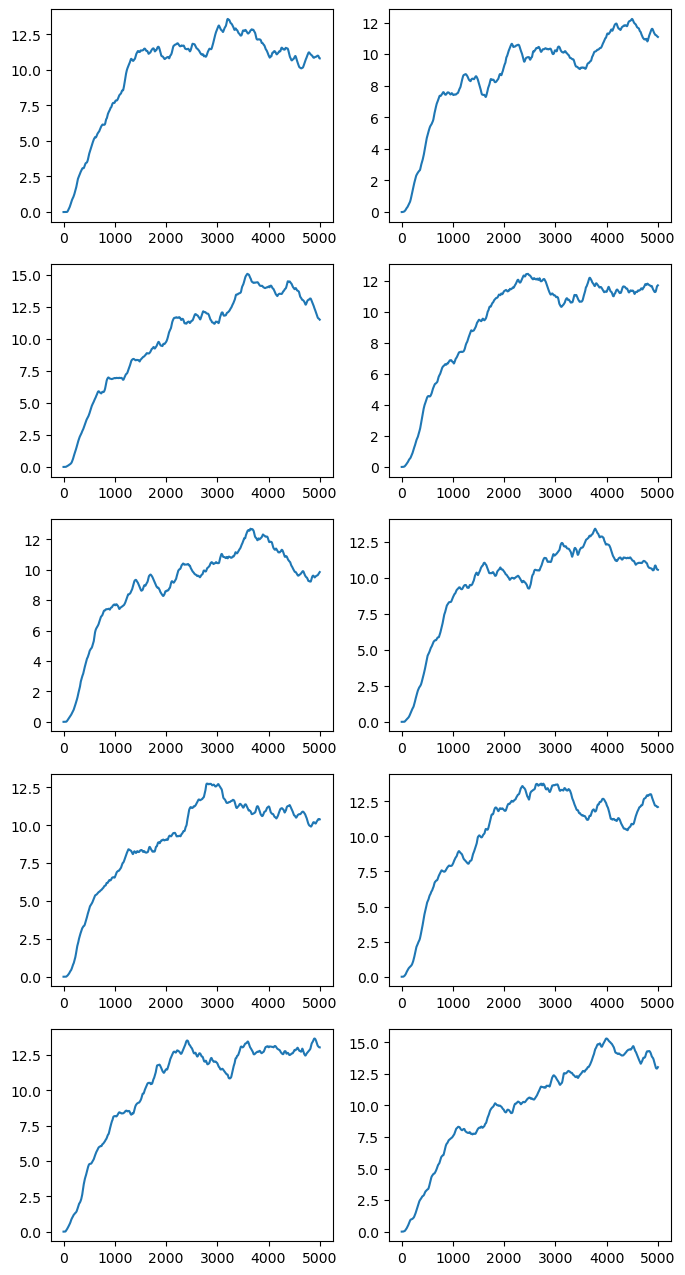

In [42]:
fig_3, axs_3 = plt.subplots(5, 2, figsize=(8, 16))
for i_path in range(10):
    i_row, i_col = divmod(i_path, 2)
    axs_3[i_row, i_col].plot(solutions[i_path].y[0])

In [43]:
solutions[9]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.250e-04 ...  6.249e-01  6.250e-01]
        y: [[ 0.000e+00  0.000e+00 ...  1.302e+01  1.303e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1304
     njev: 0
      nlu: 0

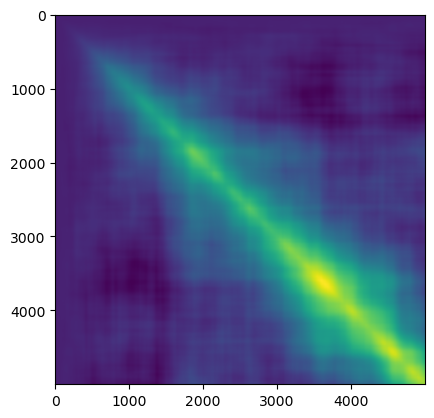

In [44]:
# Get matrix of solutions.
all_paths = np.full(
    (params['simulation']['num_paths'], params['simulation']['num_timesteps']),
    np.nan
)
for i_path, sol in enumerate(solutions):
    all_paths[i_path, :] = sol.y

# Compute covariance matrix.
mu = np.mean(all_paths, axis=0)
cov = (all_paths - mu).T @ (all_paths - mu) / (params['simulation']['num_paths'] - 1)

plt.imshow(cov)
